In [1]:
import pandas as pd 
import logging
import numpy as np
import os
import pandas as pd
import time
import plotly.express as px
from textblob import TextBlob
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
import nltk
nltk.download('words')
import contractions
from datetime import datetime
from googletrans import Translator
from collections import Counter
from itertools import combinations, combinations_with_replacement, permutations
from textblob.translate import NotTranslated
from pandas_profiling import ProfileReport
import time
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package words to
[nltk_data]     /Users/celiasagastume/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
#load data
data = pd.read_csv("./jigsaw-toxic-severity-rating/validation_data.csv")

In [3]:
#view data
data.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


In [4]:
#count number of unique workers 
data['worker'].nunique()

753

In [5]:
#create series of all comments in the dataset 

less_toxic = data['less_toxic']
more_toxic = data['more_toxic']
comments = pd.concat([less_toxic, more_toxic])
comments.shape

(60216,)

In [6]:
#create series of all unique comments in the dataset

unique_comments = [word for word in comments.unique()]
print(len(unique_comments))
print(type(unique_comments))

14251
<class 'list'>


In [7]:
unique_comments[0:5]

[' This article sucks \n\nwoo woo wooooooo',
 '"And yes, people should recognize that but they usually don\'t. One of the first objections you hear directed at someone who says he favors free markets is invariably ""There\'s no such thing as a free market."" Ridiculously trivial. "',
 ' Western Media?\n\nYup, because every crime in the entire world is caused by the west.  Racists.   ',
 "And you removed it! You numbskull! I don't care what you say anymore, this is my life! Go ahead with your own life, leave me alone! — ",
 " smelly vagina \n\nBluerasberry why don't you be a model for a cheesy blue vagina syndrome. A lot are experiencing this vaginal disease."]

In [8]:
print("Sum of terms: " + str(sum([len(d.split(' ')) for d in unique_comments])))
print("Number of documents: " + str(len(unique_comments)))


Sum of terms: 1033022
Number of documents: 14251


In [9]:
punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~__'
words = set(nltk.corpus.words.words())
stop = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
from google_trans_new import google_translator  




def to_token(text):
    
    
    text = [text.translate(str.maketrans('', '', string.punctuation))]
    text = [word_tokenize(word) for word in text]
    text = [item for sublist in text for item in sublist]
    text = [stemmer.stem(word) for word in text]
    text = [re.sub(r'http\S+', '', each) for each in text]
    text = [re.sub('[0-9+]', '', each) for each in text]
    text = [re.sub('_', '', each) for each in text]
    text = [re.sub("\n","",each) for each in text]
    text = [re.sub('/_/g', '', each) for each in text]
    text = [re.sub('[^\u0000-\u05C0\u2100-\u214F]+', '', each) for each in text]
    text = [re.sub('[\u0401\u0451\u0410-\u044f]', '', each) for each in text]
    text = [word for word in text if word not in stop]
    text = [word.lower() for word in text]
    text = ["".join(dict.fromkeys(word)) for word in text]

    return text

In [10]:
tokens = [to_token(comment) for comment in unique_comments]

In [11]:
#create tfidf matrix 
cv_tfidf = TfidfVectorizer(preprocessor=' '.join)
trans = cv_tfidf.fit_transform(tokens).toarray()
tfidf_formed = pd.DataFrame(trans, columns = cv_tfidf.get_feature_names())

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
#create CV matrix 
cv = CountVectorizer()
corpus = [str (item) for item in tokens]
trans = cv.fit_transform(corpus)
cv_formed = pd.DataFrame(trans.toarray(), columns = cv.get_feature_names())

In [13]:
#create plot topic function 
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.savefig(str(title[-16:-1])+".png",  facecolor='white', edgecolor='none')
    plt.show()

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


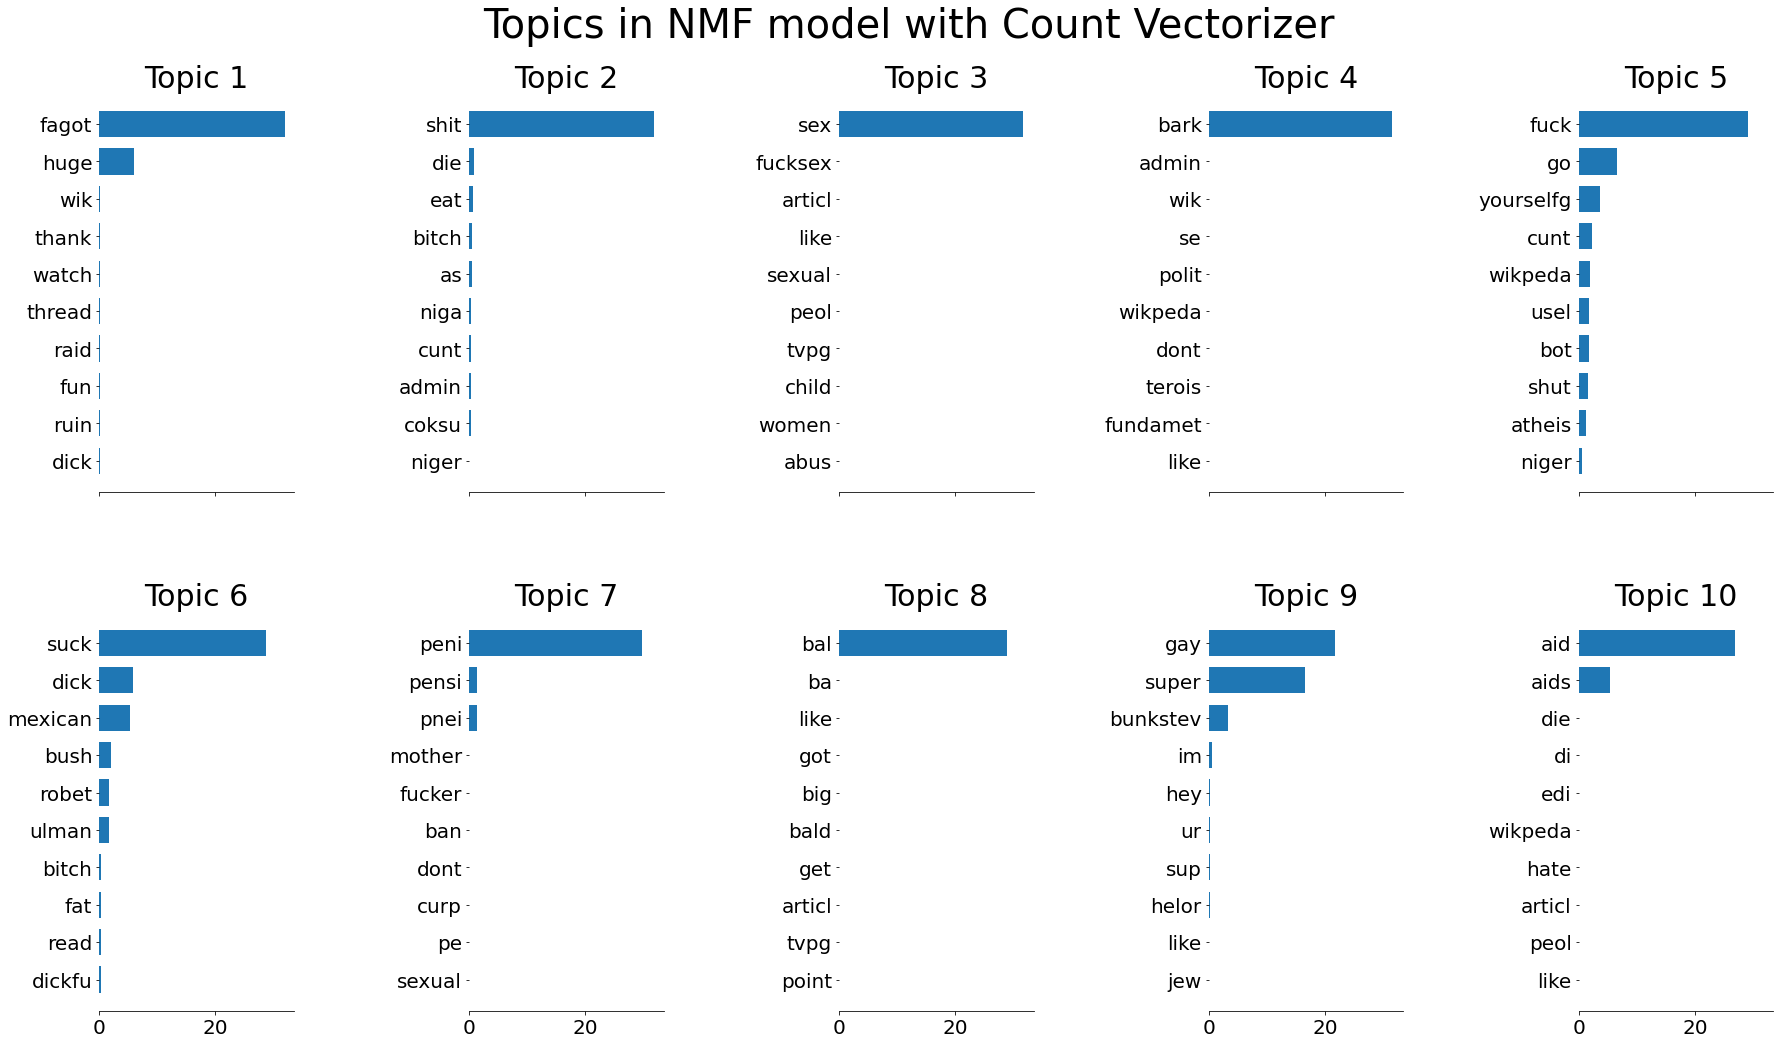

In [14]:
%matplotlib inline
count_vec = NMF(10)
nmf_5=count_vec.fit(cv_formed)
tfidf_feature_names = cv.get_feature_names_out()
plot_top_words(
    count_vec, tfidf_feature_names, 10, "Topics in NMF model with Count Vectorizer"
)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


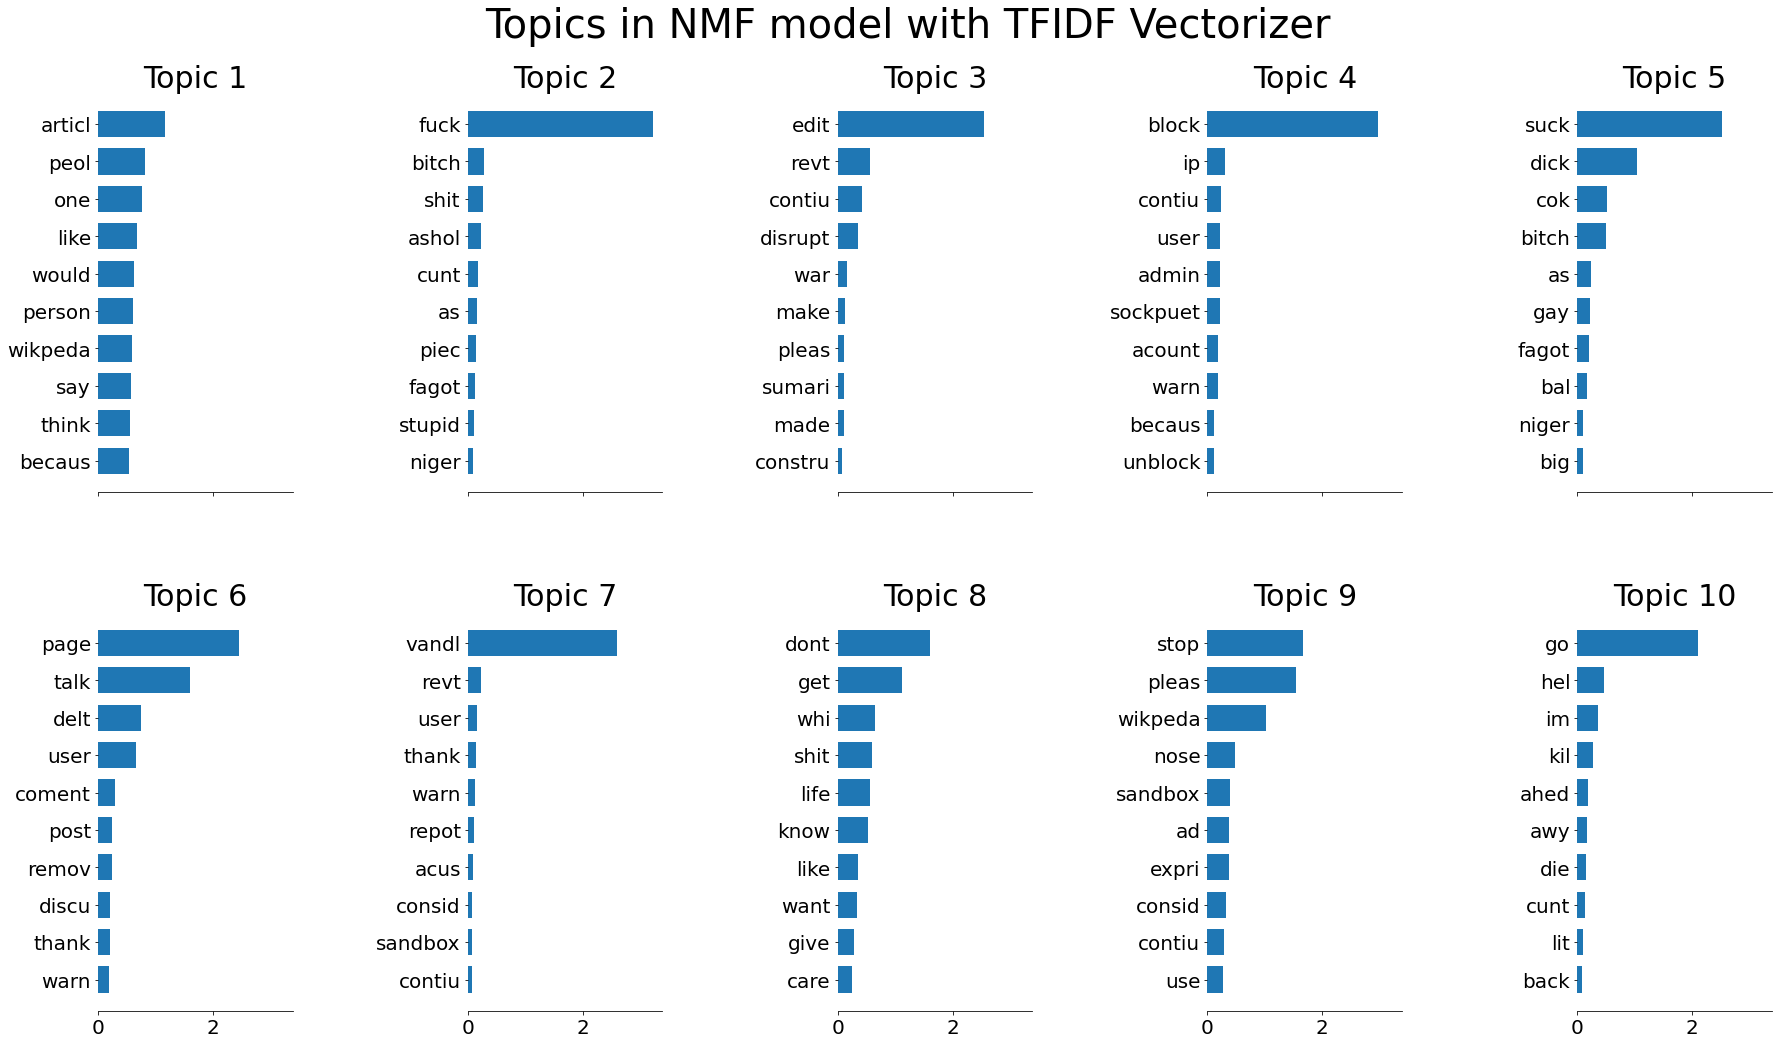

In [15]:
%matplotlib inline
nmf = NMF(10)
nmf_5=nmf.fit(tfidf_formed)
tfidf_feature_names = cv_tfidf.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, 10, "Topics in NMF model with TFIDF Vectorizer"
)